<a href="https://colab.research.google.com/github/sadat1971/sadat1971.github.io/blob/main/Neural_Network_from_scratch_Karpathy_style_(Part_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def f(x):
    return 3*x**2 - 4*x + 5

def compute_gradient(x, fun):
    h = 0.0001
    gradient = (fun(x + h) - fun(x)) / h
    return gradient

In [21]:
compute_gradient(x=3, fun=f)

14.000300000063248

## Building a network

In [22]:
class Value:
    def __init__(self, data, _ancestors=(), _op='', label='', grad=0):
        self.data = data  # The original numeric value
        self._prev = set(_ancestors)  # Ancestor nodes in the computation graph
        self._op = _op  # Operation that created this node
        self.label = label  # Optional label for visualization
        self.grad = grad
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"  # String representation of the Value object

    def __add__(self, other):
        # Overload '+' operator to create a new Value node
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __neg__(self):
        # Overload unary '-' operator to negate the value
        return self * -1

    def __sub__(self, other):
        # Overload '-' operator as addition of a negated value
        return self + (-other)

    def __mul__(self, other):
        # Overload '*' operator to create a new Value node
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def __pow__(self, other):
        # Overload '**' operator for power with scalar exponents
        assert isinstance(other, (int, float)), "only supporting int or float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        return out

    def __truediv__(self, other):
        # Overload '/' operator as multiplication by reciprocal
        return self * other**-1

    def __radd__(self, other):
        # Support reverse addition for non-Value types
        return self + other

    def __rmul__(self, other):
        # Support reverse multiplication for non-Value types
        return self * other


In [23]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
f = Value(-2.0, label='f')

e = a*b; e.label='e'
d = e+ c; d.label='d'
L = d*f; L.label='L'
L

Value(data=-8.0, label=L)

In [24]:
print("L.data :", L.data)
print("L._op :", L._op)
print("L._prev :", L._prev)


L.data : -8.0
L._op : *
L._prev : {Value(data=4.0, label=d), Value(data=-2.0, label=f)}


## Adding the gradient computation

In [25]:
class Value:
    def __init__(self, data, _ancestors=(), _op='', label='', grad=0):
        self.data = data  # The original numeric value
        self._prev = set(_ancestors)  # Ancestor nodes in the computation graph
        self._op = _op  # Operation that created this node
        self.label = label  # Optional label for visualization
        self.grad = grad
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"  # String representation of the Value object

    def __add__(self, other):
        # Overload '+' operator to create a new Value node
        ## The problem is, this way of addition will not enable us to add a value and an integer. So we do this:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad

        out._backward = _backward
        return out

    def __neg__(self):
        # Overload unary '-' operator to negate the value
        return self * -1

    def __sub__(self, other):
        # Overload '-' operator as addition of a negated value
        return self + (-other)

    def __mul__(self, other):
        # Overload '*' operator to create a new Value node
        ## The problem is, this way of multiplication will not enable us to add a value and an integer. So we do this:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        # Overload '**' operator for power with scalar exponents
        assert isinstance(other, (int, float)), "only suporting int or float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data **(other-1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        # Overload '/' operator as multiplication by reciprocal
        return self * other**-1

    def __radd__(self, other):
        # Support reverse addition for non-Value types
        return self + other

    def __rmul__(self, other):
        # Support reverse multiplication for non-Value types
        return self * other


In [26]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
f = Value(-2.0, label='f')

e = a*b; e.label='e'
d = e+ c; d.label='d'
L = d*f; L.label='L'
L

L.grad = 1.0 #Gradient with respect to itself is 1

#start backpropagating:
print("gradual backpropagation...\n")

L._backward()
print("d.grad: ", d.grad)
print("f.grad: ", f.grad)

d._backward()
print("e.grad: ", e.grad)
print("c.grad: ", c.grad)

e._backward()
print("a.grad: ", a.grad)
print("b.grad: ", b.grad)

gradual backpropagation...

d.grad:  -2.0
f.grad:  4.0
e.grad:  -2.0
c.grad:  -2.0
a.grad:  6.0
b.grad:  -4.0


## Effect of the gradients:





In [29]:
a.data += .01*a.grad
b.data += .01*b.grad
c.data += .01*c.grad
f.data += .01*f.grad

In [30]:
e = a*b
d = e + c
L = d*f

print(L.data)

-6.586368000000001


## Optional: visualization


In [ ]:
from graphviz import Digraph


In [ ]:
def trace(root):
    """
    Traces all nodes and edges in the computation graph starting from the given root.

    Args:
        root: The root node of the computation graph (typically the output of some computation).

    Returns:
        nodes: A set of all nodes in the computation graph.
        edges: A set of edges (parent, child pairs) representing dependencies between nodes.
    """
    nodes, edges = set(), set()  # Initialize sets to store nodes and edges in the computation graph

    def build(v):
        """
        Recursive helper function to traverse the computation graph and collect nodes and edges.
        """
        if v not in nodes:  # Process the node only if it hasn't been visited
            nodes.add(v)  # Add the current node to the set of nodes
            for child in v._prev:  # Iterate over all ancestor nodes (dependencies)
                edges.add((child, v))  # Add the edge from the ancestor to the current node
                build(child)  # Recursively process the ancestor node

    build(root)  # Start the traversal from the root node
    return nodes, edges  # Return the sets of nodes and edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    Visualizes the computation graph using Graphviz.

    Args:
        root: The root node of the computation graph (typically the output of some computation).
        format: The output format of the graph (e.g., 'png', 'svg').
        rankdir: The layout direction of the graph ('TB' for top-to-bottom, 'LR' for left-to-right).

    Returns:
        A Graphviz Digraph object representing the computation graph.
    """
    # Trace the computation graph to get nodes and edges
    nodes, edges = trace(root)

    # Initialize a Graphviz Digraph with specified format and layout direction
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    # Add nodes to the graph
    for n in nodes:
        # Create a node for each value in the graph with its label, data, and gradient
        dot.node(
            name=str(id(n)),  # Use the unique ID of the node as its identifier
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),  # Show label, data, and gradient
            shape='record'  # Use record-style nodes for better visualization
        )
        if n._op:  # If the node was created by an operation
            # Add a node for the operation and connect it to the value node
            dot.node(name=str(id(n)) + n._op, label=n._op)  # Label is the operation symbol
            dot.edge(str(id(n)) + n._op, str(id(n)))  # Edge from operation node to value node

    # Add edges to the graph
    for n1, n2 in edges:
        # Connect the parent node to the operation node of the child
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot  # Return the constructed Digraph


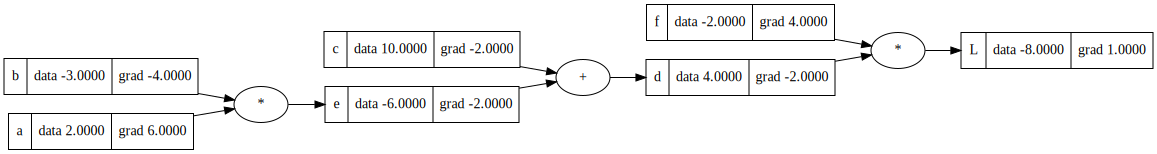

In [ ]:
draw_dot(L)

In [ ]:
##